In [1]:
# import libraries
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)
import os
from os.path import isfile, isdir, join
import numpy as np
import pandas as pd
from datetime import datetime, date
from dateutil.relativedelta import relativedelta
from bs4 import BeautifulSoup
import re
from IPython.display import display
from zipfile import ZipFile
import pickle
import unicodedata
import pytz
from joblib import Parallel, delayed
import shutil
import difflib
import random
import math
from shutil import copyfile
import itertools
import time
from tqdm import tqdm
import collections
from collections import deque
import gc
import seaborn as sns
import scipy.cluster.hierarchy as spc

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import ndcg_score, accuracy_score

import lightgbm as lgbm
import optuna
from optuna import Trial, visualization

import matplotlib as mpl
from matplotlib import pyplot as plt

import jpx_tokyo_market_prediction

from utility_script import *

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

In [2]:
'''
Notebook Parameters
'''
SEED = 0
N_STOCK_SAMPLE = 2000
N_DAY_SAMPLE = 300
N_FOLD = 5
STOCK_LIST = pd.read_csv('../input/jpx-tokyo-stock-exchange-prediction/stock_list.csv').loc[lambda x: x.Universe0==1].SecuritiesCode.sort_values().unique().tolist()[:N_STOCK_SAMPLE]
LAGS = {'1d':1, '3d':3, '1w':5, '1m':20, '3m':20*3, '6m':20*6, '12m':20*12}
# LAGS = {'3d':3, '1w':5}
MAX_DAYS_LAG = max(list(LAGS.values()))
WIN_SIZE = 500
JPX_PATH = '../input/jpx-tokyo-stock-exchange-prediction'

In [3]:
class JPXData:
    def __init__(self, window_size, df_names):
        self.size = 0
        self.window_size = window_size
        self.df_names = df_names
        self.num_df = len(df_names)
        self.data = {df_name : pd.DataFrame() for df_name in df_names}
        self.row_counts = {df_name : [] for df_name in df_names}
        self.dates = []
        self.first_date, self.last_date = None, None
        self.features = []
        self.curr_features = None
        self.n_day_hist = 0
        self.init_folders()
        
    def init_folders(self):
        shutil.rmtree(path='./features', ignore_errors=True)
        os.mkdir('./features')
        
    def append_data(self):
        self.features.append(self.curr_features)
        self.n_day_hist += 1
        
    def archive_data(self):
        save_pkl(self.features, f'./features/features_{self.n_day_hist}')
        self.clear_hist()
        
    def clear_hist(self):
        self.features = []
        
    def push_forward(self, new_data, append, last):
        # assign names to new data assuming the same as df_names
        new_data = dict(zip(self.df_names, new_data))
        # case when no enough data
        if self.size < self.window_size:
            for df_name in self.df_names:
                self.data[df_name] = pd.concat([self.data[df_name], new_data[df_name]]).reset_index(drop=True)
                self.row_counts[df_name] = self.row_counts[df_name] + [new_data[df_name].shape[0]]
            self.dates = self.dates + [new_data[self.df_names[0]].Date.iloc[0]] 
            self.size += 1
        # general case (shift by 1 day)
        else:
            for df_name in self.df_names:
                self.data[df_name] = pd.concat([self.data[df_name].iloc[self.row_counts[df_name][0]:], new_data[df_name]]).reset_index(drop=True)
                self.row_counts[df_name] = self.row_counts[df_name][1:] + [new_data[df_name].shape[0]]
            self.dates = self.dates[1:] + [new_data[self.df_names[0]].Date.iloc[0]]  
        # update date range
        self.first_date, self.last_date = self.dates[0], self.dates[-1]
        # generate features
        if self.size == self.window_size:
            self.curr_features = get_features(self.data)
            if append==True:
                self.append_data()
                if (self.n_day_hist%20 == 0 and self.n_day_hist > 0) or last==True:
                    self.archive_data()
        log(f'Pushed to latest date: {self.last_date}')

In [4]:
def standard_dist(s, lag):
    tail_data = s.tail(LAGS[lag])
    return (s.iloc[-1] - tail_data.mean()) / tail_data.std()

def ma_pctg_ch(s, lag):
    return s.iloc[-1] / s.tail(LAGS[lag]).mean() - 1

def sharpe(s, lag):
    tail_data = s.tail(LAGS[lag])
    std = tail_data.std()
    if std > 0:
        sharpe_ratio = tail_data.mean() / tail_data.std()
    else:
        sharpe_ratio = 0
    return sharpe_ratio

In [5]:
%%time

def get_features(data):
    df_prices, df_sec_prices, df_fins, df_opts, df_trades = tuple(data.values())
#     df_prices, df_sec_prices, df_fins, df_opts, df_trades = tuple(data.data.values())

    # base table
    features = df_prices.loc[lambda x: x.Date==x.Date.iloc[-1]][['RowId','Date','SecuritiesCode']]

    '''
    Major stock prices features
    '''
    # precalculate new columns
    cols = [c for c in df_prices.columns.tolist()[3:] if c!='ExpectedDividend']
    df_prices[cols] = df_prices.groupby('SecuritiesCode')[cols].ffill()
    df_prices['ret'] = df_prices.groupby('SecuritiesCode').Close.pct_change()
    ret_mkt = df_prices.groupby('Date').ret.mean()
    var_mkt = (ret_mkt**2).tail(LAGS['12m']).sum()
    df_prices['ret_mkt'] = df_prices.Date.map(ret_mkt)
    df_prices['spread'] = df_prices['High'] - df_prices['Low']
    df_prices['div_ratio'] = df_prices['ExpectedDividend'].fillna(0) / df_prices['Close']
    df_prices['dollar_traded'] = np.log(df_prices.Volume * (df_prices.Open + df_prices.Close)/2 + 1)
    df_prices['RS_sqrt_vol'] = np.sqrt(np.log(df_prices['High']/df_prices['Close'])*np.log(df_prices['High']/df_prices['Open']) + np.log(df_prices['Low']/df_prices['Close'])*np.log(df_prices['Low']/df_prices['Open']))
    df_prices['num_div'] = df_prices.groupby('SecuritiesCode').ExpectedDividend.apply(lambda s: s.notnull().astype(int).cumsum())
    df_prices['first_div'] = ((df_prices.num_div==1) & (df_prices.num_div.shift(1)==0)).astype(int)
    # previous day return
    features['ret'] = features.SecuritiesCode.map(df_prices.groupby('SecuritiesCode').ret.last())
    # Change in Close price
    for lag in ['3d','1w']:
        features[f'price_ma_pctg_ch_{lag}'] = features.SecuritiesCode.map(df_prices.groupby('SecuritiesCode').Close.apply(lambda s: ma_pctg_ch(s, lag)))
    for lag in ['1m','3m','6m','12m']:
        features[f'price_standard_dist_{lag}'] = features.SecuritiesCode.map(df_prices.groupby('SecuritiesCode').Close.apply(lambda s: standard_dist(s, lag)))
    # Change in volume
    for lag in ['3d','1w']:
        features[f'volume_ma_pctg_ch_{lag}'] = features.SecuritiesCode.map(df_prices.groupby('SecuritiesCode').Volume.apply(lambda s: ma_pctg_ch(s, lag)))
    for lag in ['1m','3m','6m','12m']:
        features[f'volume_standard_dist_{lag}'] = features.SecuritiesCode.map(df_prices.groupby('SecuritiesCode').Volume.apply(lambda s: standard_dist(s, lag)))
    # daily spread
    for lag in ['3d','1w']:
        features[f'spread_ma_pctg_ch_{lag}'] = features.SecuritiesCode.map(df_prices.groupby('SecuritiesCode').spread.apply(lambda s: ma_pctg_ch(s, lag)))
    for lag in ['1m']:
        features[f'spread_standard_dist_{lag}'] = features.SecuritiesCode.map(df_prices.groupby('SecuritiesCode').spread.apply(lambda s: standard_dist(s, lag)))
    # volatility
    for lag in ['1w','1m','3m','12m']:
        features[f'volatility_{lag}'] = features.SecuritiesCode.map(df_prices.groupby('SecuritiesCode').ret.apply(lambda s: s.tail(LAGS[lag]).std())) 
    # change in volatility
    features['volatility_diff'] = features['volatility_1w'] - features['volatility_1m']
    # market return and volatility
    for lag in ['3d','1w','1m','3m']:
        features[f'ret_mkt_{lag}'] = ret_mkt.tail(LAGS[lag]).sum()
        features[f'vol_mkt_{lag}'] = ret_mkt.tail(LAGS[lag]).std()
    # beta
    df_prices['beta'] = df_prices.SecuritiesCode.map(df_prices.groupby('SecuritiesCode').apply(lambda df: (df.set_index('Date').ret * ret_mkt).tail(LAGS['12m']).sum() / var_mkt))
    features['beta'] = features.SecuritiesCode.map(df_prices.groupby('SecuritiesCode')['beta'].last())
    # excess return
    df_prices['exret'] = df_prices['ret'] - df_prices['beta'] * df_prices['ret_mkt']
    for lag in ['3d','1w','1m','3m']:
        features[f'exret_{lag}'] = features.SecuritiesCode.map(df_prices.groupby('SecuritiesCode')['exret'].apply(lambda s: s.tail(LAGS[lag]).sum()))
    # div ratio
    features['div_ratio'] = features.SecuritiesCode.map(df_prices.groupby('SecuritiesCode').apply(lambda df: df.ExpectedDividend.fillna(0).iloc[-1] / df.Close.tail(LAGS['1m']).mean()))
    # change in dollar value traded
    for lag in ['1w','1m']:
        features[f'dollar_standard_dist_{lag}'] = features.SecuritiesCode.map(df_prices.groupby('SecuritiesCode').dollar_traded.apply(lambda s: standard_dist(s, lag)))
    # RS_sqrt_vol
    features['RS_sqrt_vol'] = features.SecuritiesCode.map(df_prices.groupby('SecuritiesCode').RS_sqrt_vol.last())
    # sharpe
    for lag in ['1m','3m']:
        features[f'sharpe_{lag}'] = features.SecuritiesCode.map(df_prices.groupby('SecuritiesCode').ret.apply(lambda s: sharpe(s, lag)))
    # days since last dividend
    features['days_since_last_div'] = features.SecuritiesCode.map((df_prices.Date.iloc[-1] - df_prices.loc[lambda x: x.ExpectedDividend.notnull()].groupby('SecuritiesCode').Date.last()) / np.timedelta64(1,'D'))
    # initiate dividend
    features['first_div'] = features.SecuritiesCode.map(df_prices.groupby('SecuritiesCode').first_div.last())
    # AdjustmentFactor
    features['AdjustmentFactor'] = features.SecuritiesCode.map(df_prices.groupby('SecuritiesCode').AdjustmentFactor.apply(lambda s: (s!=1).astype(int).iloc[-1]))


    '''
    Secondary stock prices features
    '''
    # precalculate new columns
    df_sec_prices['ret'] = df_sec_prices.groupby('SecuritiesCode').Close.pct_change()
    df_sec_prices['dollar_traded'] = np.log(df_sec_prices.Volume * (df_sec_prices.Open + df_sec_prices.Close)/2 + 1)
    # cross-sectional return & volatility
    for n in [1,3]:
        features[f'sec_cross_sect_ret_{n}'] = df_sec_prices.groupby('SecuritiesCode').ret.apply(lambda s: s.tail(n).sum()).mean()
        features[f'sec_cross_sect_vol_{n}'] = df_sec_prices.groupby('SecuritiesCode').ret.apply(lambda s: s.tail(n).sum()).std()
    # Change in volume
    for lag in ['3d','1w']:
        features[f'sec_volume_ma_pctg_ch_{lag}'] = df_sec_prices.groupby('SecuritiesCode').Volume.apply(lambda s: ma_pctg_ch(s, lag)).mean()
    # volatility
    for lag in ['1w','1m','3m']:
        features[f'sec_volatility_{lag}'] = df_sec_prices.groupby('SecuritiesCode').ret.apply(lambda s: s.tail(LAGS[lag]).std()).mean()
    # change in volatility
    features['sec_volatility_diff'] = features['sec_volatility_1w'] - features['sec_volatility_1m']
    # change in dollar value traded
    for lag in ['1w','1m']:
        features[f'sec_dollar_standard_dist_{lag}'] = df_sec_prices.groupby('SecuritiesCode').dollar_traded.apply(lambda s: standard_dist(s, lag)).mean()

    '''
    Time phase features
    '''
    # day in week
    day_in_week_angle = (features.Date.dt.weekday / 5 * 2 * np.pi).iloc[-1]
    features['day_in_week_sin'] = np.sin(day_in_week_angle)
    features['day_in_week_cos'] = np.cos(day_in_week_angle)
    # day in month
    day_in_month_angle = ((features.Date.dt.day - 1) / 31 * 2 * np.pi).iloc[-1]
    features['day_in_month_sin'] = np.sin(day_in_month_angle)
    features['day_in_month_cos'] = np.cos(day_in_month_angle)
    # week in year
    week_in_year_angle = ((features.Date.dt.week - 1) / 52 * 2 * np.pi).iloc[-1]
    features['week_in_year_sin'] = np.sin(week_in_year_angle)
    features['week_in_year_cos'] = np.cos(week_in_year_angle)


    '''
    Financials features
    '''
    # convert string to numbers
    fin_cols = ['NetSales','OperatingProfit','OrdinaryProfit','Profit','EarningsPerShare','TotalAssets','Equity','EquityToAssetRatio','BookValuePerShare',
                'ForecastNetSales','ForecastOperatingProfit','ForecastOrdinaryProfit','ForecastProfit','ForecastEarningsPerShare']
    # clean numeric values
    df_fins[fin_cols] = df_fins[fin_cols].replace('－',np.nan).astype(float)
    # quarter forward fill
    df_fins = df_fins.sort_values(['SecuritiesCode','TypeOfCurrentPeriod','Date']).reset_index(drop=True)
    df_fins[fin_cols] = df_fins.groupby(['SecuritiesCode','TypeOfCurrentPeriod'])[fin_cols].ffill()
    # overall forward fill
    df_fins = df_fins.sort_values(['SecuritiesCode','Date']).reset_index(drop=True)
    df_fins[fin_cols] = df_fins.groupby('SecuritiesCode')[fin_cols].ffill()
    # drop invalid rows
    df_fins = df_fins \
        .loc[lambda x: x.NetSales > 0] \
        .sort_values(['SecuritiesCode','Date']) \
        .reset_index(drop=True)
    # define columns
    df_fins['Close'] = df_fins.SecuritiesCode.map(df_prices.groupby('SecuritiesCode').Close.last())
    df_fins['SalesToEquityRatio'] = df_fins['NetSales'] / df_fins['Equity']
    df_fins['BookToMarketRatio'] = df_fins['Equity'] / df_fins['Close']
    df_fins['ProfitoMarketRatio'] = df_fins['OperatingProfit'] / df_fins['Close']
    df_fins['EarningToPriceRatio'] = df_fins['EarningsPerShare'] / df_fins['Close']
    fin_cols_static = ['NetSales','OperatingProfit','OrdinaryProfit','Profit','EarningsPerShare','TotalAssets','Equity','BookValuePerShare',
                        'ForecastNetSales','ForecastOperatingProfit','ForecastOrdinaryProfit','ForecastProfit','ForecastEarningsPerShare']
    fin_cols_ratio = ['EquityToAssetRatio','SalesToEquityRatio','BookToMarketRatio','ProfitoMarketRatio','EarningToPriceRatio']
    fin_cols = fin_cols_static + fin_cols_ratio
    # fins feature calculation
    df1 = df_fins.sort_values(['SecuritiesCode','TypeOfCurrentPeriod','Date']).reset_index(drop=True).groupby(['SecuritiesCode','TypeOfCurrentPeriod'])[fin_cols].nth(-1)
    df2 = df_fins.sort_values(['SecuritiesCode','TypeOfCurrentPeriod','Date']).reset_index(drop=True).groupby(['SecuritiesCode','TypeOfCurrentPeriod'])[fin_cols].nth(-2)
    df = df1.merge(df2, how='left', left_index=True, right_index=True)
    for c in fin_cols:
        if c in fin_cols_static:
            df[f'{c}_pctg'] = (df[f'{c}_x'] - df[f'{c}_y']) / df[f'{c}_y'].abs()
        elif c in fin_cols_ratio:
            df[f'{c}_raw'] = df[f'{c}_x']
            df[f'{c}_diff'] = df[f'{c}_x'] - df[f'{c}_y']
    df = df.drop([c for c in df if c[-2:] in ['_x','_y']], axis=1).reset_index()
    feats_fins = df_fins.sort_values(['SecuritiesCode','Date']).groupby('SecuritiesCode').last()['TypeOfCurrentPeriod'].reset_index()
    feats_fins = feats_fins.merge(df, how='left', on=['SecuritiesCode','TypeOfCurrentPeriod']).drop('TypeOfCurrentPeriod', axis=1)
    features = features.merge(feats_fins, how='left', on='SecuritiesCode')
    # num days since last announcement
    features['days_since_last_fin'] = (features.Date - features.SecuritiesCode.map(df_fins.groupby('SecuritiesCode').Date.last())) / np.timedelta64(1,'D')


    '''
    Post-processing
    '''
    cols = [c for c in features.columns if c not in ['RowId','Date','SecuritiesCode']]
    features[cols] = features[cols].replace(np.inf, np.nan).replace(-np.inf, np.nan)
    features[cols] = features[cols].fillna(features[cols].mean())
    features[cols] = features[cols].astype(np.float32)
    
    return features

CPU times: user 6 µs, sys: 1 µs, total: 7 µs
Wall time: 11.9 µs


In [6]:
%%time

# initialize Data Object
data = JPXData(window_size=WIN_SIZE, df_names=['df_prices', 'df_sec_prices', 'df_fins', 'df_opts', 'df_trades'])

for folder in ['train_files', 'supplemental_files']:
# for folder in ['train_files']:
    # read all files
    df_prices = pd.read_csv(f'{JPX_PATH}/{folder}/stock_prices.csv', parse_dates=['Date'])
    df_sec_prices = pd.read_csv(f'{JPX_PATH}/{folder}/secondary_stock_prices.csv', parse_dates=['Date'])
    df_fins = pd.read_csv(f'{JPX_PATH}/{folder}/financials.csv', parse_dates=['Date'])
    df_opts = pd.read_csv(f'{JPX_PATH}/{folder}/options.csv', parse_dates=['Date'])
    df_trades = pd.read_csv(f'{JPX_PATH}/{folder}/trades.csv', parse_dates=['Date'])

    # iterate dates
    date_list = df_prices.Date.sort_values().unique()
    for i in range(len(date_list)):
        last = True if i==len(date_list)-1 else False
        data.push_forward([df.loc[lambda x: x.Date==date_list[i]] for df in [df_prices, df_sec_prices, df_fins, df_opts, df_trades]], append=True, last=last)

    # release memory
    del df_prices, df_sec_prices, df_fins, df_opts, df_trades
    gc.collect()
    
save_pkl(data, 'data')

[2022-06-11 18:52:34] Pushed to latest date: 2017-01-04 00:00:00
[2022-06-11 18:52:34] Pushed to latest date: 2017-01-05 00:00:00
[2022-06-11 18:52:34] Pushed to latest date: 2017-01-06 00:00:00
[2022-06-11 18:52:34] Pushed to latest date: 2017-01-10 00:00:00
[2022-06-11 18:52:34] Pushed to latest date: 2017-01-11 00:00:00
[2022-06-11 18:52:34] Pushed to latest date: 2017-01-12 00:00:00
[2022-06-11 18:52:34] Pushed to latest date: 2017-01-13 00:00:00
[2022-06-11 18:52:34] Pushed to latest date: 2017-01-16 00:00:00
[2022-06-11 18:52:34] Pushed to latest date: 2017-01-17 00:00:00
[2022-06-11 18:52:34] Pushed to latest date: 2017-01-18 00:00:00
[2022-06-11 18:52:34] Pushed to latest date: 2017-01-19 00:00:00
[2022-06-11 18:52:34] Pushed to latest date: 2017-01-20 00:00:00
[2022-06-11 18:52:34] Pushed to latest date: 2017-01-23 00:00:00
[2022-06-11 18:52:34] Pushed to latest date: 2017-01-24 00:00:00
[2022-06-11 18:52:35] Pushed to latest date: 2017-01-25 00:00:00
[2022-06-11 18:52:35] Pus

In [7]:
# load features
path = './features'
features = pd.concat([pd.concat(load_pkl(f'{path}/{filename}')) for filename in os.listdir(path)]).sort_values('RowId').reset_index(drop=True)

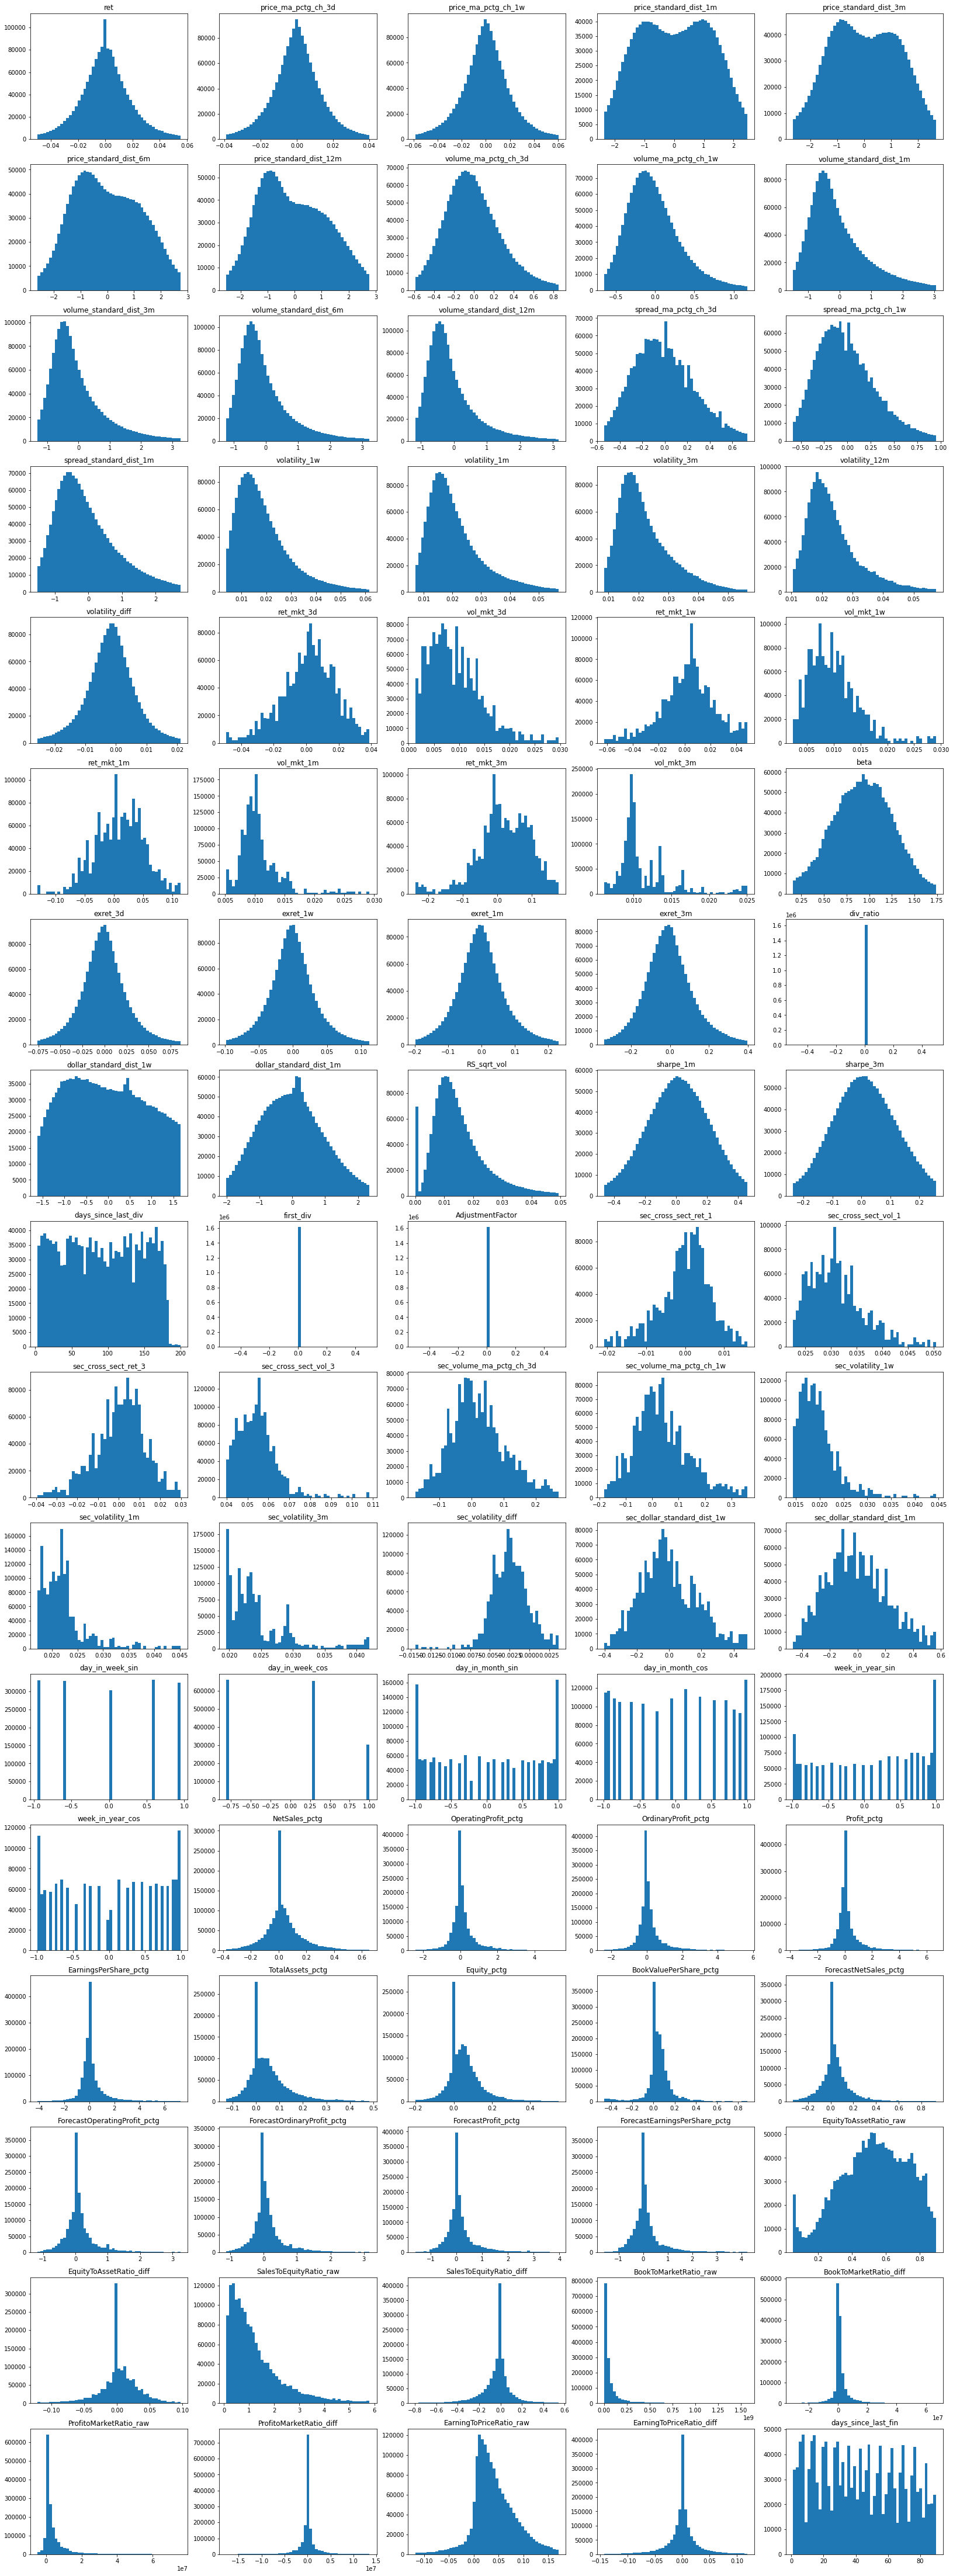

In [8]:
'''
Feature distributions
'''
n_id_cols = 3
n_col = 5
figsize = (28, 80)
top_q = 0.02
bins = 50

n_feats = features.shape[1] - n_id_cols
n_row = math.ceil(n_feats / n_col)
fig, axs = plt.subplots(n_row, n_col, figsize=figsize)
for i, j in list(itertools.product(range(n_row), range(n_col))):
    try:
        s = features.iloc[:, n_id_cols + i*n_col + j]
        s = s.loc[lambda x: (x >= s.quantile(top_q)) & (x <= s.quantile(1-top_q))]
        axs[i,j].hist(x=s, bins=bins)
        axs[i,j].set_title(features.columns.tolist()[n_id_cols + i*n_col + j])
    except:
        continue

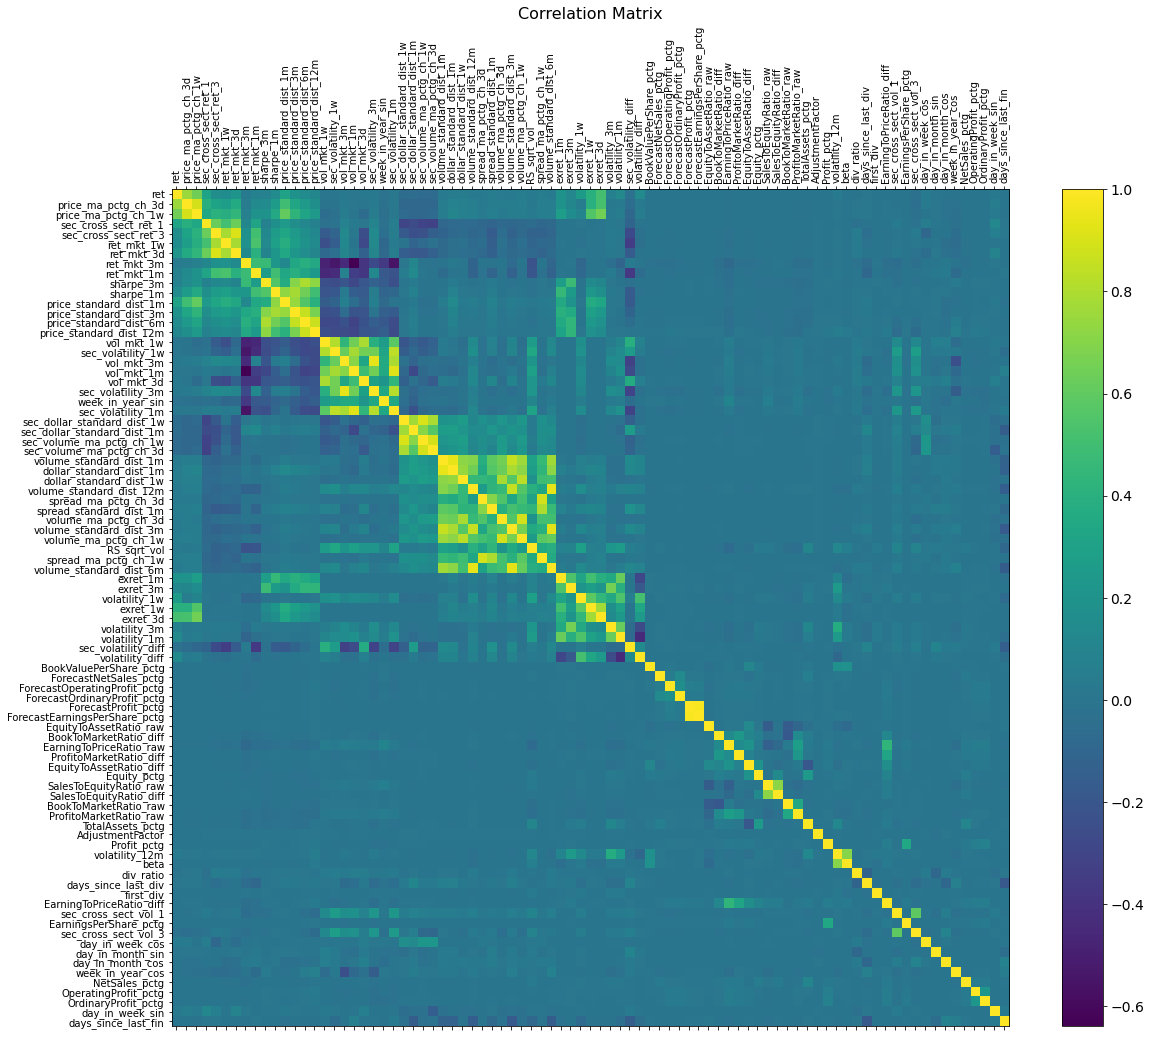

In [9]:
'''
Correlation
'''
# raw correlation table
corr = features.iloc[:,n_id_cols:].corr()
cols = [c for c in corr if corr[c].notnull().sum()==0]
corr = corr.drop(cols, axis=0).drop(cols, axis=1)
feat_names = corr.columns.tolist()

# clustering
pdist = spc.distance.pdist(corr.values)
linkage = spc.linkage(pdist, method='complete')
idx = spc.fcluster(linkage, 0.5 * pdist.max(), 'distance')
feat_corr_clust = pd.DataFrame({'feat_names':feat_names, 'clust':idx}).sort_values('clust').reset_index(drop=True)
sorted_feat_names = feat_corr_clust.feat_names
corr = corr.loc[sorted_feat_names, sorted_feat_names]

# plot the sorted correlation matrix
f = plt.figure(figsize=(19, 15))
plt.matshow(corr, fignum=f.number)
plt.xticks(range(len(sorted_feat_names)), sorted_feat_names, fontsize=10, rotation=90)
plt.yticks(range(len(sorted_feat_names)), sorted_feat_names, fontsize=10)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16)

# export
save_pkl(corr, 'corr')
save_pkl(feat_corr_clust, 'feat_corr_clust')